# Aprendizaje Multietiqueta de Patrones Geométricos en Objetos de Herencia Cultural
# CNN-RNN Multilabeling
## Seminario de Tesis II, Primavera 2022
### Master of Data Science. Universidad de Chile.
#### Prof. guía: Benjamín Bustos - Prof. coguía: Iván Sipirán
#### Autor: Matías Vergara

El objetivo de este notebook es realizar predicciones multilabel sobre patrones geométricos mediante CNN-RNN.

Código basado en la implementación del usuario velej en https://github.com/jennynanap/Yelp_Image_Classification/blob/master/ML%20Models/CNN_RNN.py, agregando importantes modificaciones (principalmente relacionadas al Beam Search).

## Imports

In [9]:
root_dir = '..'

In [10]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import torchvision.models as models
import math 
from torch.nn.utils.rnn import pack_padded_sequence
%matplotlib inline
import sys 
import cv2 
import pickle
import math

from utils import KunischMetrics
from utils import KunischPruner
from utils import DataExplorer
from utils import KunischPlotter

## Configuración de dispositivo

In [11]:
# 0 es 3090, 1 y 2 son 2080
CUDA_ID = 0

device = torch.device(f'cuda:{CUDA_ID}' if torch.cuda.is_available() else 'cpu')
print(f"Usando device: {torch.cuda.get_device_name(device)}")

Usando device: NVIDIA GeForce RTX 3090


## Selección de dataset y experimento

In [12]:
DS_FLAGS = []
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'gausblur': [gausblur]
              # 'msblur': [msblur]
              # 'mtnblur': [mtnblur]
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
CROP_TIMES = 1
RANDOM_TIMES = 1
ELASTIC_TIMES = 1
GAUSBLUR_TIMES = 1

use_pos_weights = True
pos_weights_factor = 1
NUM_LABELS = 107
BATCH_SIZE = 128

num_epochs = 300
patience = 15

# 0 es 3090, 1 y 2 son 2080
CUDA_ID = 0

SAVE = True
K = 4

In [13]:
# This cells builds the data_flags variable, that will be used
# to map the requested data treatment to folders
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
         'gausblur': GAUSBLUR_TIMES,
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = ['crop', 'randaug', 'elastic', 'gausblur']
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

Kfolds = {}

for i in range(0, K):
    print("Fold ", i)
    patterns_dir = os.path.join(root_dir, 'patterns', data_flags, str(i))
    labels_dir = os.path.join(root_dir, 'labels', data_flags, str(i))

    if not (os.path.isdir(patterns_dir) and os.path.isdir(labels_dir)):
        print(patterns_dir)
        print(labels_dir)
        raise FileNotFoundError("""
        No existen directorios de datos para el conjunto de flags seleccionado. 
        Verifique que el dataset exista y, de lo contrario, llame a Split and Augmentation.
        """)
        
    exp_name = f"{NUM_LABELS}L"
    weights_str = str(pos_weights_factor)
    weights_str = weights_str.replace('.','_')
    exp_name += f'_weighted_{weights_str}' if use_pos_weights else ''
    print(f"Nombre del experimento: {exp_name}")
     
    output_dir = os.path.join(root_dir, "outputs", "cnn-rnn", data_flags, exp_name, str(i))
    model_dir = os.path.join(root_dir, "models", "cnn-rnn", data_flags, str(i))
    model_path = os.path.join(model_dir, exp_name)
    
    path_co = os.path.join(patterns_dir, 'train', 'circular ornaments')
    path_lz = os.path.join(patterns_dir, 'train', 'lozenge')
    path_pc = os.path.join(patterns_dir, 'train', 'pictographics')
    path_ro = os.path.join(patterns_dir, 'train', 'rectangular ornaments')
    path_sl = os.path.join(patterns_dir, 'train', 'strokes and lines')
    path_to = os.path.join(patterns_dir, 'train', 'triangular ornaments')
    
    ex_co = os.listdir(path_co)[random.randint(0, 5)].split('.')[0]
    ex_co = os.path.join(path_co, ex_co)

    ex_lz = os.listdir(path_lz)[random.randint(0, 5)].split('.')[0]
    ex_lz = os.path.join(path_lz, ex_lz)

    ex_pc = os.listdir(path_pc)[random.randint(0, 5)].split('.')[0]
    ex_pc = os.path.join(path_pc, ex_pc)
    
    ex_ro = os.listdir(path_ro)[random.randint(0, 5)].split('.')[0]
    ex_ro = os.path.join(path_ro, ex_ro)

    ex_sl = os.listdir(path_sl)[random.randint(0, 5)].split('.')[0]
    ex_sl = os.path.join(path_sl, ex_sl)

    ex_to = os.listdir(path_to)[random.randint(0, 5)].split('.')[0]
    ex_to = os.path.join(path_to, ex_to)
    
    Kfolds[i] = {
        'patterns_dir': patterns_dir,
        'labels_dir': labels_dir,
        'output_dir': output_dir,
        'model_path': model_path,
        'ex_photos': [ex_co, ex_lz, ex_pc, ex_ro, ex_sl, ex_to]
    }
    
    print("--Pattern set encontrado en {}".format(patterns_dir))
    print("--Labels set encontrado en {}".format(labels_dir))
    print("")
    

    if SAVE:
        os.makedirs(output_dir, exist_ok = True)
        os.makedirs(model_dir, exist_ok = True)
        print(f"Los resultados se guardarán en: {output_dir}")
        print(f"Los modelos se guardarán en: {model_dir}")

Fold  0
Nombre del experimento: 107L_weighted_1
--Pattern set encontrado en ../patterns/base/0
--Labels set encontrado en ../labels/base/0

Los resultados se guardarán en: ../outputs/cnn-rnn/base/107L_weighted_1/0
Los modelos se guardarán en: ../models/cnn-rnn/base/0
Fold  1
Nombre del experimento: 107L_weighted_1
--Pattern set encontrado en ../patterns/base/1
--Labels set encontrado en ../labels/base/1

Los resultados se guardarán en: ../outputs/cnn-rnn/base/107L_weighted_1/1
Los modelos se guardarán en: ../models/cnn-rnn/base/1
Fold  2
Nombre del experimento: 107L_weighted_1
--Pattern set encontrado en ../patterns/base/2
--Labels set encontrado en ../labels/base/2

Los resultados se guardarán en: ../outputs/cnn-rnn/base/107L_weighted_1/2
Los modelos se guardarán en: ../models/cnn-rnn/base/2
Fold  3
Nombre del experimento: 107L_weighted_1
--Pattern set encontrado en ../patterns/base/3
--Labels set encontrado en ../labels/base/3

Los resultados se guardarán en: ../outputs/cnn-rnn/base/

## Funciones auxiliares

In [20]:
# Construct Data Loader
class KunischDataset(torch.utils.data.Dataset):
    
    def __init__(self, images_dir, labels_file, transform, top_labels):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.pruner = KunischPruner(len(top_labels))
        self.pruner.set_top_labels(top_labels)
        labels = pd.read_json(labels_file, orient='index')
        self.labels_frame = self.pruner.filter_df(labels)
        self.num_labels = len(top_labels)
        self.images_dir = images_dir
        self.labels_file = labels_file
        self.transform = transform
        self.flags = data_flags
        self.top_labels = top_labels
                                       
    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_id = self.labels_frame.iloc[idx].name + '.png'
        img_name = None
        for chapter in os.listdir(self.images_dir):
          if img_id in os.listdir(os.path.join(self.images_dir, chapter)):
            img_name = os.path.join(self.images_dir, chapter, img_id)
            break
        if img_name is None:
          raise Exception(f'No se encontró la imagen para {img_id}')
        image = Image.open(img_name)
        image = image.convert('RGB')
        image = self.transform(image)

        labels = self.labels_frame.iloc[idx].values
        labels = np.where(labels)[0].tolist()
        labels = list(map(int, labels))
        labels = [self.num_labels] + labels + [self.num_labels + 1] #start and end
        # [26 ... 0 ... ... 27]
        labels = [x + 1 for x in labels] # add 1 to all labels so 0 has no meaning
        # [27 ... 1 ... ... 28]
        length = len(labels) 
        for i in range(self.num_labels + 2 - length): #Pad the labels (There are num_labels unique labels)
            labels = labels + [0]
        # [27 ... 1 ... ... 28 0 0 0 ... 0]
        target = torch.Tensor(labels).long()
        
        sample = {'image': image, 'labels': target, 'lengths': length,
                  'paths': img_name}
        
        return sample
 

# Define Beam Search   
def beam_search(k, s, predicted, x, y, pred_sequence_list, prob_sequence_list, real_num_labels):
  #Inputs Definitions:
  #k: Top labels to consider
  #s: current state
  #predicted: result of lstm (softmax)
  #x: current path of labels
  #y: current paht of probabilities 
  #prediction_paths: list of all label paths
  #probability_paths: list of all probability paths
    
    #si se predice end, terminar
    if predicted == real_num_labels + 2:
        #print(x)
        #print(y)
        pred_sequence_list.append(x)
        prob_sequence_list.append(y)
        #print("PREDICHO END")
    # caso contrario: calculo un nuevo estado
    else:
        inputs = decoder.embedding(predicted) 
        outputs, s = decoder.execute_lstm(inputs, s)
        scores = torch.softmax(outputs[0],dim=0)
        top_k_scores = scores.topk(k)[1].unsqueeze(0)
        top_k_probs = scores.topk(k)[0].unsqueeze(0)
        #print(top_k_scores)
        #print(top_k_probs)

        sequences = x.expand(k,len(x))
        prob_sequences = y.expand(k,len(x))
        #print(sequences)
        #print(top_k_scores[0][0].unsqueeze(0))
        #step =1
        
        # para cada top k, itero (bajo un nivel del arbol)
        for i in range(top_k_scores.size(1)):
            x = torch.cat((sequences[i], top_k_scores[0][i].unsqueeze(0) ))
            y = torch.cat((prob_sequences[i], top_k_probs[0][i].unsqueeze(0) ))
            
            #el nuevo predicho es el ultimo elemento de x 
            predicted = x[len(x)-1].unsqueeze(0)
            
             #si todavia no predigo ningun label aparte de start y end o si hay uno nuevo, itero
            if (x[len(x)-2]== real_num_labels + 1 and len(pred_sequence_list)<2) or predicted not in x[:-1]:
                #print('This is predicted: ', x[:-1])
                #print('This is x: ',x)
                # itero de nuevo pero con este nuevo estado, este nuevo predicted,
                # x e y, ..
                beam_search(k,s,predicted,x,y,pred_sequence_list,prob_sequence_list, real_num_labels)
            

#Generate Sample Images with Captions
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.convert('RGB')
    image = image.resize([227, 227], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image


#Define the CNN RNN architecture
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the Alexnet Architecture modifying where appropriate"""
        super(EncoderCNN, self).__init__()
        alex_net = models.alexnet(pretrained=True)
        alex_net.classifier._modules['6'] = nn.Linear(4096, embed_size)

        
        self.alex_net = alex_net
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        features = self.alex_net(images)
        features = features.reshape(features.size(0), -1)
        #print(np.shape(features))
        #print(features.size())
        features = self.bn(features)
        return features

    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def execute_lstm(self, features, states=None):
        """Generate labels for given image """

        inputs = features.unsqueeze(1)
        for i in range(1): # range(1):#:
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)

        return outputs, states
    
    def embedding(self, features, states=None):
        """Embedd predicted label"""
        for i in range(1):#range(1):#self.max_seg_length):
            inputs = self.embed(features)                       # inputs: (batch_size, embed_size)
        return inputs

## Experimentos

../outputs/cnn-rnn/base/107L_weighted_1/0
Usando top_labels previamente generados para 107 labels
104
Vocabulary size:  107 (se agregaron las palabras <padding>, <start> y <end>)


/home/mavergar/anaconda3/envs/Kunisch_10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mavergar/anaconda3/envs/Kunisch_10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 11.277917454008422
Epoch [0/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 3.285021659655449
Epoch [1/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 1.5458291183317328
Epoch [1/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 1.742821522248097
Epoch [2/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.926197287664248
Epoch [2/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 1.1570844405736678
Epoch [3/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.829856621736736
Epoch [3/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 1.1907313420222356
Mala epoca
Epoch [4/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001,

Epoch [35/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.18646658190413018
Epoch [35/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.6479556743915265
Mala epoca
Epoch [36/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.17895344468210475
Epoch [36/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.632052250397511
Mala epoca
Epoch [37/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.17854572479435474
Epoch [37/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.4995149954771384
Mala epoca
Epoch [38/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.18117245497731116
Epoch [38/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.5316092662322216
Mala epoca
Epoch [39/300], Embedded 

Epoch [69/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.14976532955390182
Epoch [69/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.40777697929969203
Epoch [70/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.14595413190781037
Epoch [70/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.4638160314315405
Mala epoca
Epoch [71/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.14373351900563763
Epoch [71/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.4708412366035657
Mala epoca
Epoch [72/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.14423716447256893
Epoch [72/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.4068244787362906
Epoch [73/300], Embedded Size: 52, Hidden Siz

Epoch [103/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.13888734492952423
Epoch [103/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3810689877241086
Epoch [104/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.13550723977171616
Epoch [104/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.4062098723191481
Mala epoca
Epoch [105/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1361485409598819
Epoch [105/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3902693283863557
Mala epoca
Epoch [106/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1350568017863125
Epoch [106/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3864181958712064
Mala epoca
Epoch [107/300], Embedded Siz

Epoch [137/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1330089784426496
Epoch [137/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3767240964449369
Mala epoca
Epoch [138/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12756926131386287
Epoch [138/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3705293948833759
Mala epoca
Epoch [139/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12572438455041432
Epoch [139/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.37307081467066056
Mala epoca
Epoch [140/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1277953341517145
Epoch [140/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3804793235583183
Mala epoca
Epoch [141/300], 

Epoch [171/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12108724964836429
Epoch [171/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.357994128496219
Mala epoca
Epoch [172/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12176149325563729
Epoch [172/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3638818936470227
Mala epoca
Epoch [173/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12211705081035636
Epoch [173/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3577356827564729
Mala epoca
Epoch [174/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.11981864230481186
Epoch [174/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.357206784761869
Mala epoca
Epoch [175/300], E

Epoch [205/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.11875650079953189
Epoch [205/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.34583722628079927
Mala epoca
Epoch [206/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.11594875268853469
Epoch [206/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.35998769906850964
Mala epoca
Epoch [207/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.11583579878586565
Epoch [207/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.34619791079790163
Mala epoca
Epoch [208/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1178584782718923
Epoch [208/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.34163832053160054
Mala epoca
Epoch [209/30

Epoch [239/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.10994125532277058
Epoch [239/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.33344029157589644
Mala epoca
Epoch [240/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1128067961662491
Epoch [240/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3307354266826923
Epoch [241/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.11137361540270678
Epoch [241/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.33371548774914866
Mala epoca
Epoch [242/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.10754855726495643
Epoch [242/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.33818222926213193
Mala epoca
Epoch [243/300], Embedded

Epoch [273/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1076699991446699
Epoch [273/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.318575076567821
Mala epoca
Epoch [274/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.10657199424815315
Epoch [274/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.32531503530649036
Mala epoca
Epoch [275/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1064448513392079
Epoch [275/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3230798916938977
Mala epoca
Epoch [276/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.10371291895822293
Epoch [276/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3479000971867488
Mala epoca
Epoch [277/300], E

/tmp/ipykernel_2359422/1147033589.py:111: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize([227, 227], Image.LANCZOS)


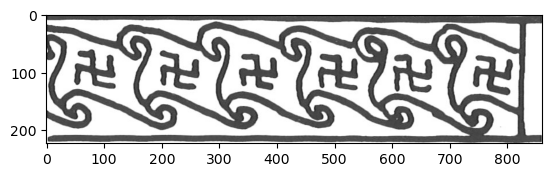

<start> panel horizontal <end>
Labels: [105   1   2 106] 
Prediction Path Probability: -3.5511

Working photo  ../patterns/base/0/train/lozenge/43b_msblur


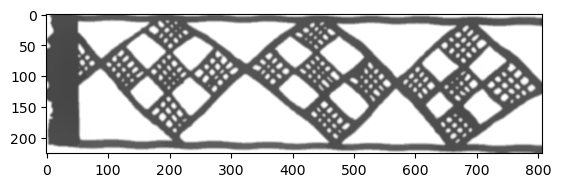

<start> panel horizontal <end>
Labels: [105   1   2 106] 
Prediction Path Probability: -4.6595

Working photo  ../patterns/base/0/train/pictographics/94a_rain


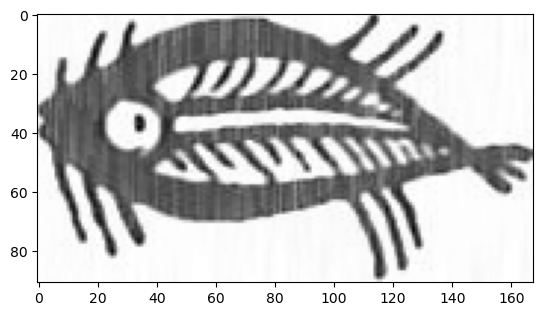

<start> panel small <end>
Labels: [105   1  58 106] 
Prediction Path Probability: -4.5855

Working photo  ../patterns/base/0/train/rectangular ornaments/18e_embs


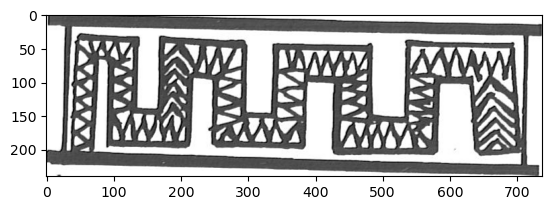

<start> horizontal ornament zigzag single <end>
Labels: [105   2   3  24  25 106] 
Prediction Path Probability: -4.7191

Working photo  ../patterns/base/0/train/strokes and lines/8f_rot180


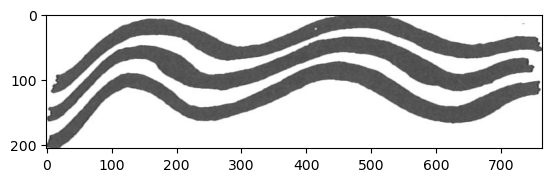

<start> enclosing double line metope <end>
Labels: [105  10  11  22  81 106] 
Prediction Path Probability: -4.2365

Working photo  ../patterns/base/0/train/triangular ornaments/65d_embs


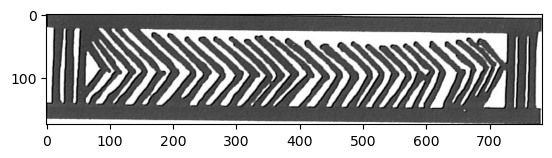

<start> panel horizontal <end>
Labels: [105   1   2 106] 
Prediction Path Probability: -4.1952

['<padding>', 'panel', 'horizontal', 'ornament', 'vertical', 'hatched', 'metopal', 'circle', 'filling', 'lozenge', 'enclosing', 'double', 'cross-hatched', 'triangle', 'concentric', 'bar', 'chain', 'dotted', 'meander', 'solid', 'outline', 'cross', 'line', 'dot', 'zigzag', 'single', 'hook', 'swastika', 'floor', 'star', 'multiple', 'shoulder', 'turning', 'triple', 'battlement', 'left', 'quatrefoil', 'checkerboard', 'reserved', 'tangential', 'stacked', 'right', 'chevron', 'pendent', 'scribble', 'parallel', 'rosette', 'bird', "andrew's", 'hour-glass', 'rectilinear', 'semicircle', 'row', 'band', 'floating', 'leaf', 'hatching', 'pattern', 'small', 'body', 'centre', 'rectangle', 'eight-pointed', 'simple', 'net', 'tree', 'standing', 'quartered', 'octofoil', 'square', 'link', 'sigma', 'apex', 'group', 'diagonal', 'field', 'ax', 'alternating', 'background', 'quarter', 'tongue', 'metope', 'latticed', 'c

/home/mavergar/anaconda3/envs/Kunisch_10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mavergar/anaconda3/envs/Kunisch_10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 12.010011725670383
Epoch [0/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 3.5244007599659457
Epoch [1/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 2.2588631910879124
Epoch [1/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 2.8227098905123196
Epoch [2/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 1.6065119663617669
Epoch [2/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 1.4980358221592047
Epoch [3/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.6755021693760407
Epoch [3/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 1.2258278284317408
Epoch [4/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2

Epoch [35/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.18637004786595077
Epoch [35/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.575439208593124
Epoch [36/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.17851171435358534
Epoch [36/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.5959339141845703
Mala epoca
Epoch [37/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.17769353843992827
Epoch [37/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.6007337325658554
Mala epoca
Epoch [38/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.17898559707187178
Epoch [38/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.7144794464111328
Mala epoca
Epoch [39/300], Embedded Size: 52, H

Epoch [69/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.14284455737718596
Epoch [69/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.46332618517753404
Epoch [70/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.14389500414379874
Epoch [70/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.47595958220653045
Mala epoca
Epoch [71/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1418357439523621
Epoch [71/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.49799444736578524
Mala epoca
Epoch [72/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.14052180795631916
Epoch [72/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.4575489239814954
Epoch [73/300], Embedded Size: 52, Hidden Si

Epoch [103/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12950909347315182
Epoch [103/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.4625193277994792
Mala epoca
Epoch [104/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12670924204158066
Epoch [104/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.43663621560121196
Epoch [105/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12608922490262625
Epoch [105/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.43226217612242085
Epoch [106/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12762247947197386
Epoch [106/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.45095174740522337
Mala epoca
Epoch [107/300], Embedded Size: 52,

Epoch [137/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.11980183474428131
Epoch [137/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.42693191919571316
Mala epoca
Epoch [138/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12034115587719718
Epoch [138/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.41644913110977566
Epoch [139/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12247011350995116
Epoch [139/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.42714544442983776
Mala epoca
Epoch [140/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.11941885648767794
Epoch [140/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.4375035212590144
Mala epoca
Epoch [141/300], Embedde

/tmp/ipykernel_2359422/1147033589.py:111: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize([227, 227], Image.LANCZOS)


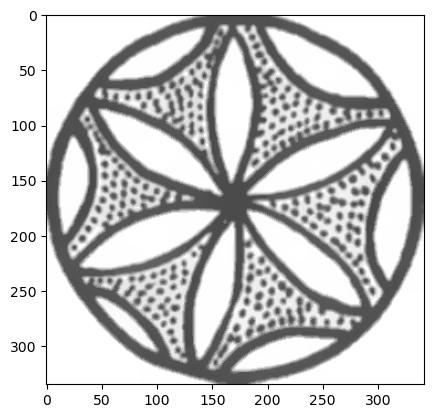

<start> <end>
Labels: [105 106] 
Prediction Path Probability: -0.1062

Working photo  ../patterns/base/1/train/lozenge/36h_embs


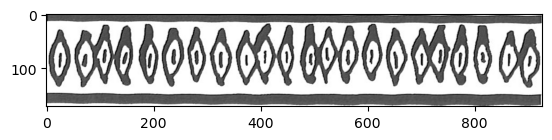

<start> rectilinear small latticed <end>
Labels: [105  50  58  82 106] 
Prediction Path Probability: -3.1973

Working photo  ../patterns/base/1/train/pictographics/90i_embs


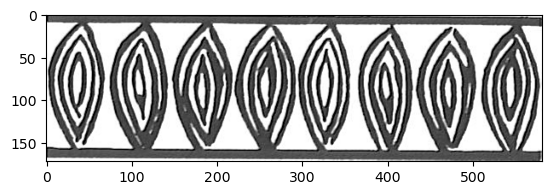

<start> <end>
Labels: [105 106] 
Prediction Path Probability: -0.0318

Working photo  ../patterns/base/1/train/rectangular ornaments/21g


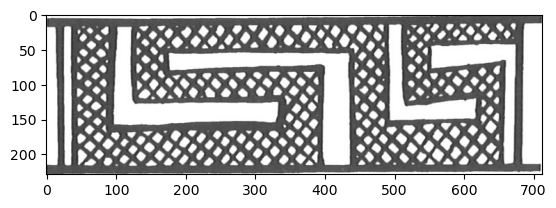

<start> <end>
Labels: [105 106] 
Prediction Path Probability: -0.0317

Working photo  ../patterns/base/1/train/strokes and lines/8f_rot180


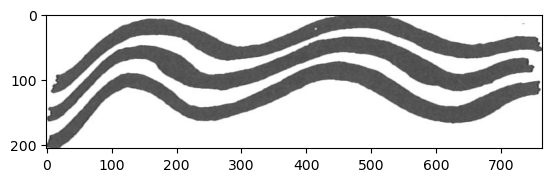

<start> rectilinear small latticed <end>
Labels: [105  50  58  82 106] 
Prediction Path Probability: -3.1401

Working photo  ../patterns/base/1/train/triangular ornaments/48b_gausblur0


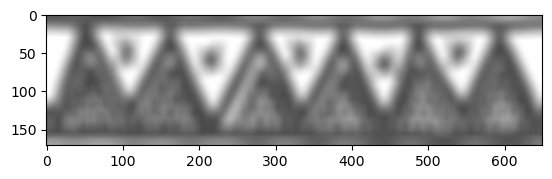

<start> rectilinear small latticed <end>
Labels: [105  50  58  82 106] 
Prediction Path Probability: -2.9356

['<padding>', 'panel', 'horizontal', 'ornament', 'vertical', 'hatched', 'metopal', 'circle', 'filling', 'lozenge', 'enclosing', 'double', 'cross-hatched', 'triangle', 'concentric', 'bar', 'chain', 'dotted', 'meander', 'solid', 'outline', 'cross', 'line', 'dot', 'zigzag', 'single', 'hook', 'swastika', 'floor', 'star', 'multiple', 'shoulder', 'turning', 'triple', 'battlement', 'left', 'quatrefoil', 'checkerboard', 'reserved', 'tangential', 'stacked', 'right', 'chevron', 'pendent', 'scribble', 'parallel', 'rosette', 'bird', "andrew's", 'hour-glass', 'rectilinear', 'semicircle', 'row', 'band', 'floating', 'leaf', 'hatching', 'pattern', 'small', 'body', 'centre', 'rectangle', 'eight-pointed', 'simple', 'net', 'tree', 'standing', 'quartered', 'octofoil', 'square', 'link', 'sigma', 'apex', 'group', 'diagonal', 'field', 'ax', 'alternating', 'background', 'quarter', 'tongue', 'metope', 

/home/mavergar/anaconda3/envs/Kunisch_10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mavergar/anaconda3/envs/Kunisch_10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 11.892543509441396
Epoch [0/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 7.995665721404246
Epoch [1/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 2.3518734927132736
Epoch [1/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 2.082599346454327
Epoch [2/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.8673860182758708
Epoch [2/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 1.0735750442896135
Epoch [3/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.6162620797463261
Epoch [3/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.9793877234825721
Epoch [4/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-

Epoch [35/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.16947384918861966
Epoch [35/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.49788802709334934
Epoch [36/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.16970631469473532
Epoch [36/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.4916877746582031
Epoch [37/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1694033209505748
Epoch [37/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.6664113264817458
Mala epoca
Epoch [38/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.16716210551629757
Epoch [38/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.49922850193121493
Mala epoca
Epoch [39/300], Embedded Size: 52, Hidden Siz

Epoch [69/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1417839925926885
Epoch [69/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.446113048455654
Mala epoca
Epoch [70/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1426068534933584
Epoch [70/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.446686280079377
Mala epoca
Epoch [71/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.14200535710973541
Epoch [71/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.5071101555457482
Mala epoca
Epoch [72/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.14147450739991863
Epoch [72/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.4249254373403696
Mala epoca
Epoch [73/300], Embedded Siz

Epoch [103/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12834827110934102
Epoch [103/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3670135155702249
Epoch [104/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.1289592366813324
Epoch [104/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.36668968200683594
Epoch [105/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12819248803158673
Epoch [105/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.36863953027969754
Mala epoca
Epoch [106/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12825383861544498
Epoch [106/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.4046204640315129
Mala epoca
Epoch [107/300], Embedded Size: 52, H

Epoch [137/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12271179135273752
Epoch [137/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3763268544123723
Mala epoca
Epoch [138/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12161155303949578
Epoch [138/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.36136813041491384
Mala epoca
Epoch [139/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12205542672342247
Epoch [139/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.35432228675255406
Mala epoca
Epoch [140/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.12452073086915294
Epoch [140/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3555224002935948
Mala epoca
Epoch [141/300

Epoch [171/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.11949520379240425
Epoch [171/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3449700428889348
Mala epoca
Epoch [172/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.11831862770058564
Epoch [172/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.35548090323423726
Mala epoca
Epoch [173/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.11910833690178506
Epoch [173/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.3466944816784981
Mala epoca
Epoch [174/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.11874425024460268
Epoch [174/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 0.35134538014729816
Mala epoca
Epoch [175/300

/tmp/ipykernel_2359422/1147033589.py:111: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize([227, 227], Image.LANCZOS)


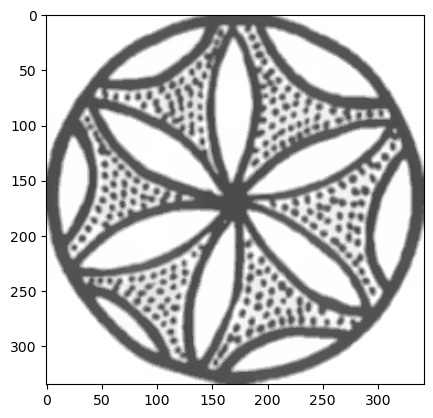

<start> <end>
Labels: [105 106] 
Prediction Path Probability: -0.0961

Working photo  ../patterns/base/2/train/lozenge/36c_gausblur0


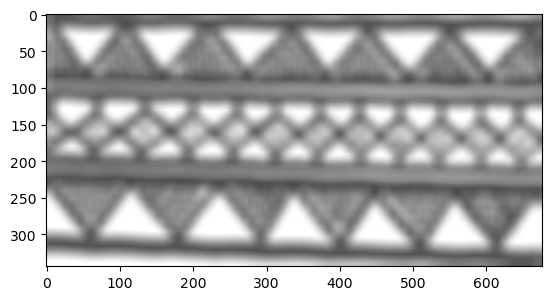

<start> <end>
Labels: [105 106] 
Prediction Path Probability: -1.8430

Working photo  ../patterns/base/2/train/pictographics/95k_rain


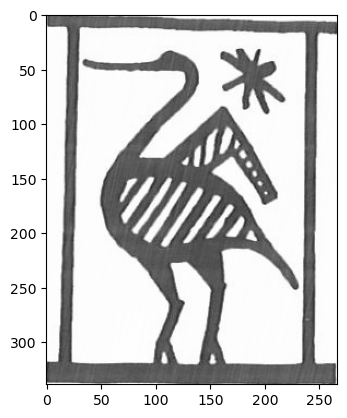

<start> <end>
Labels: [105 106] 
Prediction Path Probability: -0.9232

Working photo  ../patterns/base/2/train/rectangular ornaments/11e_rot270


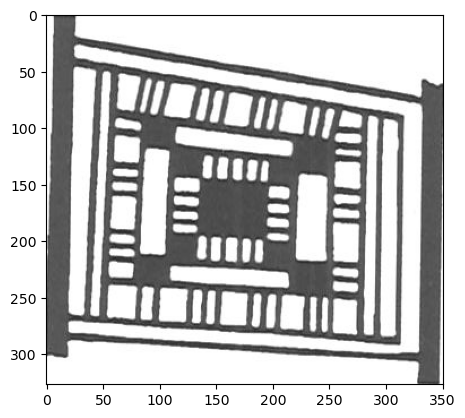

<start> panel gear-pattern <end>
Labels: [105   1  84 106] 
Prediction Path Probability: -3.6205

Working photo  ../patterns/base/2/train/strokes and lines/3i_rot90


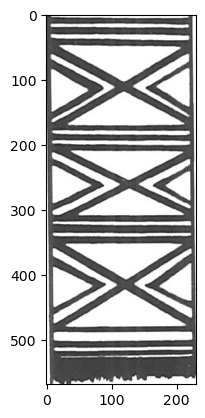

<start> panel gear-pattern <end>
Labels: [105   1  84 106] 
Prediction Path Probability: -3.8666

Working photo  ../patterns/base/2/train/triangular ornaments/53c_msblur


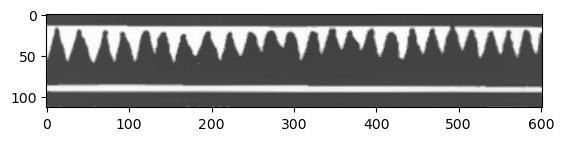

<start> rectilinear small <end>
Labels: [105  50  58 106] 
Prediction Path Probability: -3.9739

['<padding>', 'panel', 'horizontal', 'ornament', 'vertical', 'hatched', 'metopal', 'circle', 'filling', 'lozenge', 'enclosing', 'double', 'cross-hatched', 'triangle', 'concentric', 'bar', 'chain', 'dotted', 'meander', 'solid', 'outline', 'cross', 'line', 'dot', 'zigzag', 'single', 'hook', 'swastika', 'floor', 'star', 'multiple', 'shoulder', 'turning', 'triple', 'battlement', 'left', 'quatrefoil', 'checkerboard', 'reserved', 'tangential', 'stacked', 'right', 'chevron', 'pendent', 'scribble', 'parallel', 'rosette', 'bird', "andrew's", 'hour-glass', 'rectilinear', 'semicircle', 'row', 'band', 'floating', 'leaf', 'hatching', 'pattern', 'small', 'body', 'centre', 'rectangle', 'eight-pointed', 'simple', 'net', 'tree', 'standing', 'quartered', 'octofoil', 'square', 'link', 'sigma', 'apex', 'group', 'diagonal', 'field', 'ax', 'alternating', 'background', 'quarter', 'tongue', 'metope', 'latticed', '

/home/mavergar/anaconda3/envs/Kunisch_10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mavergar/anaconda3/envs/Kunisch_10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 11.123230549785502
Epoch [0/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 6.012529030824319
Epoch [1/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 1.3693526748624223
Epoch [1/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 8.472976293319311
Mala epoca
Epoch [2/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.9120839015132847
Epoch [2/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 1.316429920685597
Epoch [3/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Avg Loss: 0.8348877046635964
Epoch [3/300], Embedded Size: 52, Hidden Size: 256, Layers: 1, LR: 0.001, W: 2.2e-05, Val Loss: 1.8709053626427283
Mala epoca
Epoch [4/300], Embedded Size: 52, Hidden Size: 256, Layers: 1

In [ ]:
recall = 0
prec = 0
acc = 0
f1 = 0
f2 = 0
hs = 0
emr = 0
mr1 = 0
mr2 = 0
mr3 = 0
mr4 = 0
mr5 = 0
for fold_i in range(0, K):
    fold = Kfolds[fold_i]
    labels_dir = fold['labels_dir']
    patterns_dir = fold['patterns_dir']
    output_dir = fold['output_dir']
    print(output_dir)
    model_path = fold['model_path']
    photos = fold['ex_photos']
    # Carga de top labels
    train_labels = pd.read_json(os.path.join(labels_dir, 'augmented_train_df.json'), orient='index')

    if not os.path.isfile(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle')):
        print(f"Creando top_labels para {NUM_LABELS} labels")
        top_labels = pruner.filter_labels(train_labels)
        pruner.set_top_labels(top_labels)

        save = input(f"Se creará un archivo nuevo para {len(top_labels)} labels. Desea continuar? (y/n)")
        if save == "y":
            with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'wb') as f:
                pickle.dump(top_labels, f)
            print("Top labels creado con éxito")

        else:
            raise Exception("No se logró cargar top_labels")

    else: 
        print(f"Usando top_labels previamente generados para {NUM_LABELS} labels")
        with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'rb') as f:
            top_labels = pickle.load(f)
    
    REAL_NUM_LABELS = len(top_labels)
    kunischTrainSet = KunischDataset(images_dir=os.path.join(patterns_dir, 'train'),
                                     labels_file=os.path.join(labels_dir, 'augmented_train_df.json'),
                                     transform=transforms.Compose([transforms.Resize((227, 227)),
                                                                   transforms.ToTensor(),
                                                                   transforms.Normalize(
                                                                       mean=[0.485, 0.456, 0.406],
                                                                       std=[0.229, 0.224, 0.225])]),
                                     top_labels=top_labels)

    kunischTrainLoader = torch.utils.data.DataLoader(kunischTrainSet, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    # Validation
    kunischValidationSet = KunischDataset(images_dir=os.path.join(patterns_dir, 'val'),
                                          labels_file=os.path.join(labels_dir, 'val_df.json'),
                                          transform=transforms.Compose([transforms.Resize((227, 227)),
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize(
                                                                            mean=[0.485, 0.456, 0.406],
                                                                            std=[0.229, 0.224, 0.225])]),
                                          top_labels=top_labels)

    kunischValidationLoader = torch.utils.data.DataLoader(kunischValidationSet, batch_size=BATCH_SIZE, shuffle=True,
                                                          num_workers=0)

    # Test
    kunischTestSet = KunischDataset(images_dir=os.path.join(patterns_dir, 'test'),
                                    labels_file=os.path.join(labels_dir, 'test_df.json'),
                                    transform=transforms.Compose([transforms.Resize((227, 227)),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize(
                                                                      mean=[0.485, 0.456, 0.406],
                                                                      std=[0.229, 0.224, 0.225])]),
                                    top_labels=top_labels)

    kunischTestLoader = torch.utils.data.DataLoader(kunischTestSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(len(top_labels))

    #### 
    # Training the Model
    os.makedirs(model_path, exist_ok = True)
    os.makedirs(output_dir, exist_ok = True)
    encoder_path = os.path.join(model_path, 'encoder.pth')
    decoder_path = os.path.join(model_path, 'decoder.pth')


    vocab = list(top_labels.index.values)
    vocab = ['<padding>'] + vocab + ['<start>', '<end>']
    print("Vocabulary size: ", len(vocab), "(se agregaron las palabras <padding>, <start> y <end>)")

    embed_size = REAL_NUM_LABELS//2
    hidden_size = 256
    num_layers = 1
    # Build the models
    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

    learning_rate = 0.001
    w = 2.20e-05

    def get_class_weight(labels):
        samples = len(labels)
        sums = labels.sum(axis=0).values.tolist()
        sums = [0] + sums + [0] + [0]
        weights = []
        for s in sums:
            #print("Suma:" ,s)
            #print("Samples:" ,samples)
            weight = samples/(s+1)
            #print("Weight:", weight)
            weights.append(weight)
        return weights

    class_weights = get_class_weight(kunischTrainSet.labels_frame)
    # Loss and optimizer
    class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    params = list(decoder.parameters()) + list(encoder.alex_net.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.RMSprop(params, lr=learning_rate, alpha=0.9, eps=1e-08, weight_decay=w)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=5, min_lr=0.0001)


    best_loss = math.inf
    bad_epochs = 0
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0
        encoder.train()
        decoder.train()
        for i, sample_batched in enumerate(kunischTrainLoader):

            # Set mini-batch dataset
            unsorted_images = sample_batched['image']
            unsorted_labels = sample_batched['labels']
            unsorted_lengths = sample_batched['lengths']
            sorted_length_index = sorted(range(len(unsorted_lengths)),key=unsorted_lengths.__getitem__,reverse=True)
            inputs =[]
            labels = []
            lengths = []
            for j in sorted_length_index:
                inputs.append(unsorted_images[j])
                labels.append(unsorted_labels[j])
                lengths.append(unsorted_lengths[j])
            #inputs = unsorted_images
            #labels = unsorted_labels
            #lengths = unsorted_lengths
            inputs =torch.stack(inputs).to(device)
            labels = torch.stack(labels).to(device)
            lengths = torch.stack(lengths)
            targets = pack_padded_sequence(labels , lengths, batch_first=True)[0].to(device)

            decoder.zero_grad()
            encoder.zero_grad()

            #print(labels)
            #print(targets)
            # Forward, backward and optimize
            features = encoder(inputs)
            outputs = decoder(features, labels , lengths)
            #print(np.shape(outputs))
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss/len(kunischTrainLoader.dataset)*1024
        train_losses.append([epoch, train_loss])

        print('Epoch [{}/{}], Embedded Size: {}, Hidden Size: {}, Layers: {}, LR: {}, W: {}, Avg Loss: {}'
              .format(epoch, num_epochs, embed_size, hidden_size,
                      num_layers, learning_rate, w, train_loss ))


        for i, sample_batched in enumerate(kunischValidationLoader):

            # Set mini-batch dataset
            unsorted_images = sample_batched['image']
            unsorted_labels = sample_batched['labels']
            unsorted_lengths = sample_batched['lengths']
            sorted_length_index = sorted(range(len(unsorted_lengths)),key=unsorted_lengths.__getitem__,reverse=True)
            inputs =[]
            labels = []
            lengths = []
            for j in sorted_length_index:
                inputs.append(unsorted_images[j])
                labels.append(unsorted_labels[j])
                lengths.append(unsorted_lengths[j])
            #inputs = unsorted_images
            #labels = unsorted_labels
            #lengths = unsorted_lengths
            inputs =torch.stack(inputs).to(device)
            labels = torch.stack(labels).to(device)
            lengths = torch.stack(lengths)
            targets = pack_padded_sequence(labels , lengths, batch_first=True)[0].to(device)

            decoder.zero_grad()
            encoder.zero_grad()

            #print(labels)
            #print(targets)
            # Forward, backward and optimize
            features = encoder(inputs)
            outputs = decoder(features, labels , lengths)
            #print(np.shape(outputs))
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            val_loss += loss.item()

        val_loss = val_loss/len(kunischValidationLoader.dataset)*1024
        scheduler.step(val_loss)
        val_losses.append([epoch, val_loss])

        print('Epoch [{}/{}], Embedded Size: {}, Hidden Size: {}, Layers: {}, LR: {}, W: {}, Val Loss: {}'
              .format(epoch, num_epochs, embed_size, hidden_size,
                      num_layers, learning_rate, w, val_loss ))

        if val_loss < best_loss:
            best_loss = val_loss
            bad_epochs = 0
            torch.save(encoder.state_dict(), encoder_path)
            torch.save(decoder.state_dict(), decoder_path)
        else:
            print("Mala epoca")
            bad_epochs += 1
            if bad_epochs == patience:
                print("Se acabo la paciencia\n")
                break

    print("Cargando modelos")

    #Load Parameters
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    print("Modelos cargados")

    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))])
    show_examples = True
    if show_examples:
        for i in photos:
            print("Working photo ", i)
            img_name = i  +'.png'

            image = load_image(img_name, transform).to(device)
            encoder.eval()
            decoder.eval()
            prediction_paths = []
            probability_paths = []
            # Encode - read the image features
            encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
            output_sample, s = decoder.execute_lstm(encoder_out)
            _, predicted = output_sample.max(1)  

            sequences = predicted
            prob_sequences = torch.sigmoid(output_sample.max()).detach()

            #print("Calling to beam search")
            beam_search(2, s, predicted, sequences, prob_sequences, prediction_paths, probability_paths, 
                       REAL_NUM_LABELS)
            index_val = 0
            #print("After beam search")

            for j in range(0, len(prediction_paths)):
                score = np.sum(np.log(probability_paths[j].detach().cpu().numpy()))
                if j == 0:
                    best = score
                elif best < score:
                    best = score
                    index_val = j

            sampled_ids = prediction_paths[index_val].cpu().numpy()
            sampled_prob = best
            sampled_caption = []

            for word_id in sampled_ids:
                word = vocab[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)

            # Print out the image and the generated caption

            image = cv2.imread(img_name)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            plt.imshow(image)
            plt.show()
            print (sentence)
            print('Labels: {} \nPrediction Path Probability: {:.4f}'.format( sampled_ids,sampled_prob))
            print()

        ####

    #Run Models on Test data using Beam Search

    vocab = list(top_labels.index.values)
    vocab = ['<padding>'] + vocab + ['<start>', '<end>']
    print(vocab)

    TP, TN, FP, FN = 0, 0, 0, 0
    test_pred = []

    images = []
    im_labels = []
    for sample in kunischTestLoader:
        images = images + sample['paths']
        lbl = sample['labels'].cpu().detach().numpy()
        for i in lbl:
            im_labels.append(i)

    for i, j  in zip(images, im_labels):
        img_name = i
        labels = j
        labels = list(map(int, labels))
        try:
            labels.remove(REAL_NUM_LABELS + 1)
            labels.remove(REAL_NUM_LABELS + 2)
        except:
            print("Etiquetas no incorporan start, end")

        transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))])
        encoder.eval()
        decoder.eval()

        # Prepare an image
        image = load_image(img_name, transform)
        image_tensor = image.to(device)

        # Generate an caption from the image
        prediction_paths = []
        probability_paths = []
        # Encode - read the image features
        encoder_out = encoder(image_tensor)  # (1, enc_image_size, enc_image_size, encoder_dim)
        output_sample, s = decoder.execute_lstm(encoder_out)
        _, predicted = output_sample.max(1)  

        predicted = torch.tensor([REAL_NUM_LABELS + 1]).to(device)
        sequences = predicted
        prob_sequences = torch.sigmoid(output_sample.max())
        prob_sequences

        beam_search(2, s, predicted, sequences, prob_sequences,prediction_paths, probability_paths,
                   REAL_NUM_LABELS)
        for k in range(len(prediction_paths)):
            score_k = np.sum(np.log(probability_paths[k].detach().cpu().numpy()))
            if k==0:
                best = score_k
                index_val = k 
            elif best < score_k:
                best = score_k
                index_val = k

        sampled_ids = prediction_paths[index_val].cpu().numpy()

        pred = sampled_ids


        end = np.argwhere(pred==REAL_NUM_LABELS + 2)[0][0]
        start_where = np.argwhere(pred==REAL_NUM_LABELS + 1)
        start = start_where[len(start_where)-1][0]+1
        pred = pred[start:end]

        pred2 = np.zeros(REAL_NUM_LABELS)
        labels2 = np.zeros(REAL_NUM_LABELS)

        for p in pred:
            pred2[p-1]=1
        for l in labels:
            labels2[l-1]=1   
        test_pred.append([img_name,labels2,pred2])
        TP += ((pred2==1)&(labels2==1)).sum()
        TN += ((pred2==0)&(labels2==0)).sum()
        FP += ((pred2==1)&(labels2==0)).sum()
        FN += ((pred2==0)&(labels2==1)).sum()

    ####
    final_labels = []
    final_preds = []
    for elem in test_pred:
        final_preds.append(elem[2])
        final_labels.append(elem[1])

    metrics = KunischMetrics(np.array(final_labels), np.array(final_preds))
    recall += metrics.recall()
    prec += metrics.precision()
    acc += metrics.acc()
    f1 += metrics.f1()
    hs += metrics.hs()
    emr += metrics.emr()
    mr1 += metrics.mr1()
    mr2 += metrics.mr2()
    mr3 += metrics.mr3()
    mr4 += metrics.mr4()
    mr5 += metrics.mr5()
    f2 += metrics.f2()

    if SAVE:
        df = pd.DataFrame(np.array(final_preds))
        df.to_csv(os.path.join(output_dir, 'predictions.csv'))

avg_recall = round(recall/K, 4)
avg_prec = round(prec/K, 4)
avg_acc = round(acc/K, 4)
avg_f1 = round(f1/K, 4)
avg_f2 = round(f2/K, 4)
avg_hs = round(hs/K, 4)
avg_emr = round(emr/K, 4)
avg_mr1 = round(mr1/K, 4)
avg_mr2 = round(mr2/K, 4)
avg_mr3 = round(mr3/K, 4)
avg_mr4 = round(mr4/K, 4)
avg_mr5 = round(mr5/K, 4)

print("Recall", avg_recall)
print("Precision", avg_prec)
print("Accuracy", avg_acc)
print("F1", avg_f1)
print("F2", avg_f2)
print("HS", avg_hs)
print("EMR", avg_emr)
print("1MR", avg_mr1)
print("2MR", avg_mr2)

if SAVE:
    results_dict = {
        'recall': avg_recall,
        'precision': avg_prec,
        'acc': avg_acc,
        'f1': avg_f1,
        'f2': avg_f2,
        'hs': avg_hs,
        'emr': avg_emr,
        'mr1': avg_mr1,
        'mr2': avg_mr2,
        'mr3': avg_mr3,
        'mr4': avg_mr4,
        'mr5': avg_mr5
    }

    final_df = pd.DataFrame.from_dict(results_dict, orient='index')
    final_df.to_csv(os.path.join(output_dir, '..', 'metadata.csv'))